# Imports

In [40]:
import os, sys
import re

import kagglehub
from scipy.io import loadmat
from scipy.fft import fft, rfft, rfftfreq, fftfreq

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import polars as pl
import pandas as pd

from torch.utils.data import Dataset, DataLoader

# Data load

In [2]:
path = kagglehub.dataset_download("brjapon/cwru-bearing-datasets")

print("Path to dataset files:", path)

Path to dataset files: /home/mihalko711/.cache/kagglehub/datasets/brjapon/cwru-bearing-datasets/versions/1


In [3]:
os.listdir(Path(path) / os.listdir(path)[-1])

['B007_1_123.mat',
 'B014_1_190.mat',
 'B021_1_227.mat',
 'IR007_1_110.mat',
 'IR014_1_175.mat',
 'IR021_1_214.mat',
 'OR007_6_1_136.mat',
 'OR014_6_1_202.mat',
 'OR021_6_1_239.mat',
 'Time_Normal_1_098.mat']

In [4]:
def parse_cwru_files(folder_path):
    data_list = []
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.mat'):
            continue
            
        # 1. Загружаем .mat файл
        file_path = os.path.join(folder_path, filename)
        mat_dict = loadmat(file_path)
        
        # 2. Вытаскиваем ID из названия (последние цифры перед .mat)
        # Например из 'B007_1_123.mat' вытащит '123'
        match = re.search(r'(\d{3})\.mat$', filename)
        if not match: continue
        file_id = match.group(1)
        
        # 3. Ищем ключ с данными вибрации (Drive End - DE)
        # Ключ выглядит как 'X123_DE_time'
        de_key = f'X{file_id}_DE_time'
        
        if de_key in mat_dict:
            signal = mat_dict[de_key].flatten()
            
            # 4. Определяем тип дефекта (Label)
            if 'Normal' in filename:
                label = 'Normal'
            elif 'IR' in filename:
                label = 'Inner Race'
            elif 'OR' in filename:
                label = 'Outer Race'
            elif 'B' in filename:
                label = 'Ball'
            else:
                label = 'Unknown'
                
            # 5. Определяем тяжесть (диаметр дефекта)
            severity = 0
            if '007' in filename: severity = 7
            elif '014' in filename: severity = 14
            elif '021' in filename: severity = 21

            data_list.append({
                'filename': filename,
                'label': label,
                'severity': severity,
                'signal': signal
            })
            
    return pl.DataFrame(data_list)

In [5]:
raw_path = Path(path) / 'raw'
df = parse_cwru_files(raw_path)

print(df[['filename', 'label', 'severity']])

shape: (10, 3)
┌───────────────────────┬────────────┬──────────┐
│ filename              ┆ label      ┆ severity │
│ ---                   ┆ ---        ┆ ---      │
│ str                   ┆ str        ┆ i64      │
╞═══════════════════════╪════════════╪══════════╡
│ B007_1_123.mat        ┆ Ball       ┆ 7        │
│ B014_1_190.mat        ┆ Ball       ┆ 14       │
│ B021_1_227.mat        ┆ Ball       ┆ 21       │
│ IR007_1_110.mat       ┆ Inner Race ┆ 7        │
│ IR014_1_175.mat       ┆ Inner Race ┆ 14       │
│ IR021_1_214.mat       ┆ Inner Race ┆ 21       │
│ OR007_6_1_136.mat     ┆ Outer Race ┆ 7        │
│ OR014_6_1_202.mat     ┆ Outer Race ┆ 14       │
│ OR021_6_1_239.mat     ┆ Outer Race ┆ 21       │
│ Time_Normal_1_098.mat ┆ Normal     ┆ 0        │
└───────────────────────┴────────────┴──────────┘


# Let's look on CWRU

# Описание набора данных CWRU Bearing Dataset

**Case Western Reserve University (CWRU) Bearing Dataset** — это «золотой стандарт» и наиболее часто используемый бенчмарк в задачах диагностики состояния вращающегося оборудования и прогнозирования поломок (Predictive Maintenance) с помощью машинного обучения.

### 1. Обзор экспериментальной установки
Данные были собраны на стенде, состоящем из:
*   Электродвигателя мощностью **2 л.с.** (Reliance Electric).
*   Торсионного датчика и энкодера.
*   Динамометра и управляющей электроники.

### 2. Характеристики повреждений
Повреждения наносились на подшипники методом электроэрозионной обработки (EDM). 
*   **Типы дефектов:**
    *   **IR** (Inner Race) — повреждение внутреннего кольца.
    *   **OR** (Outer Race) — повреждение внешнего кольца (позиции на 3, 6 и 12 часов относительно зоны нагрузки).
    *   **B** (Ball) — повреждение тела качения (шарика).
*   **Диаметры повреждений:** 0.007, 0.014, 0.021 и 0.028 дюймов.

### 3. Условия сбора данных
Данные представляют собой записи вибрации (ускорения), собранные при различных нагрузках на двигатель:
*   **Нагрузка:** от 0 до 3 л.с. (соответствует скоростям вращения от 1730 до 1797 об/мин).
*   **Частота дискретизации:**
    *   **12 кГц** — для данных со стороны привода (Drive End) и вентилятора (Fan End).
    *   **48 кГц** — для некоторых данных со стороны привода.
*   **Точки замера:** акселерометры на корпусе двигателя со стороны привода (**DE**), со стороны вентилятора (**FE**) и на базовой плите (**BA**).

### 4. Структура данных
Файлы поставляются в формате `.mat` (MATLAB). Типичная структура файла включает:
*   `X[ID]_DE_time`: временной ряд вибрации со стороны привода.
*   `X[ID]_FE_time`: временной ряд вибрации со стороны вентилятора.
*   `X[ID]_RPM`: фактическая скорость вращения во время эксперимента.

### 5. Применение в ML
Обычно задача на этом датасете формулируется как **многоклассовая классификация**, где целью является определение типа дефекта и/или его размера. 
> **Важно:** При разделении на обучающую и тестовую выборки следует избегать утечки данных (Data Leakage), возникающей из-за того, что записи одного и того же физического подшипника при разных нагрузках могут попасть в разные части выборки.

---

In [32]:
fault_type = 'Ball'
severity = 21

# signal for specific anomaly
signal = df.filter(
    pl.col('label') == fault_type,
    pl.col('severity') == severity
)['signal'][0]

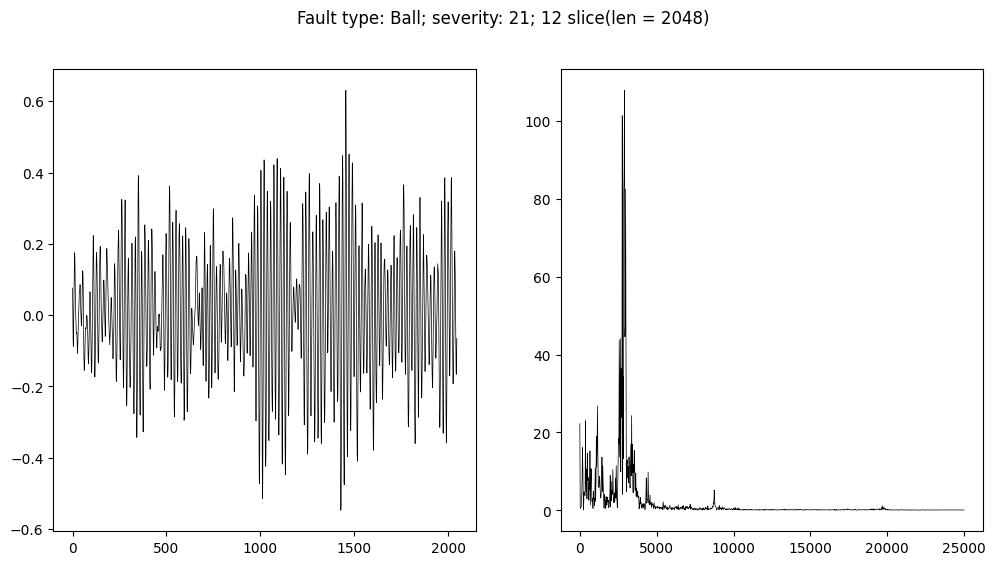

In [33]:
slice_id = 12
slice_len = 2048

signal_slice = signal[slice_id * slice_len : (slice_id + 1) * slice_len]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle(f"Fault type: {fault_type}; severity: {severity}; {slice_id} slice(len = {slice_len})")

ax[0].plot(signal_slice, c='k', lw=0.5)

spec_slice = rfft(signal_slice)
freqs = rfftfreq(len(signal_slice), d=1/50_000)

ax[1].plot(freqs, np.abs(spec_slice), c='k', lw=0.5)

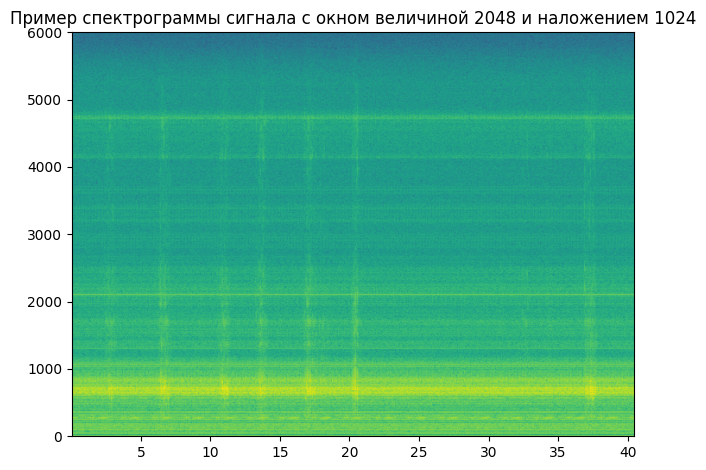

In [39]:
plt.specgram(signal, NFFT=2048, Fs=12000, noverlap=1024)
plt.title(f"Пример спектрограммы сигнала с окном величиной 2048 и наложением 1024")
plt.tight_layout()

# Dataset class

In [62]:
class RawCWRUDataset(Dataset):
    def  __init__(self, signal, width, overlap):
        self.signal = signal
        self.signal_len = len(signal)
        self.width = width
        self.overlap = overlap

    def __getitem__(self, idx):
        start = idx * (self.width - self.overlap)
        end = start + self.width
        return self.signal[start : end]

    def __len__(self):
        return (self.signal_len - self.width) // (self.width - self.overlap) + 1

def train_val_test_split(signal, fracs):
    if sum(fracs) != 1.0 or len(fracs) != 3:
        raise Exception("Fractions must add up to 1. and length must be 3")

    first = int(fracs[0] * len(signal))
    second = int((fracs[0] + fracs[1]) * len(signal))

    return signal[:first], signal[first:second], signal[second:]

In [63]:
width = 2048
overlap = 1024

split_fracs = [0.7, 0.2, 0.1]

train_sig, val_sig, test_sig = train_val_test_split(signal, split_fracs)
train_ds, val_ds, test_ds = RawCWRUDataset(train_sig, width, overlap), RawCWRUDataset(val_sig, width, overlap), RawCWRUDataset(test_sig, width, overlap)

# Models

## Simple U-net like 1D-CNN